In [3]:
import pandas as pd
import glob
import os
import librosa
import numpy as np
import scripts

import matplotlib.pyplot as plt
%matplotlib inline

# Loading data

## Annotations

In [4]:
elan_annotation_paths = scripts.find_annotation_paths('.txt')
praat_annotation_paths = scripts.find_annotation_paths('.TextGrid')

In [5]:
elan_annotations = scripts.get_elan_annotations(elan_annotation_paths)
praat_annotations = scripts.get_praat_annotations(praat_annotation_paths)

In [6]:
annotations = elan_annotations.copy()
annotations.extend(praat_annotations)

In [9]:
annotations_paths = elan_annotation_paths.copy()
annotations_paths.extend(praat_annotation_paths)

In [15]:
annotations_names = [p.split('/')[-1] for p in annotations_paths]

In [68]:
data = []
for ann in annotations:
    data.append({
        'total_time': ann.finish.max() / 60,
        'a_counts': ann.label.value_counts().get('a', 0),
        'b_counts': ann.label.value_counts().get('b', 0),
        'a_length': ann.groupby('label').sum().length.get('a', 0),
        'b_length': ann.groupby('label').sum().length.get('b', 0),
    })
data = pd.DataFrame(data)

In [69]:
data['name'] = annotations_names

In [70]:
data['a_frac'] = data['a_length'] / data['total_time'] / 60
data['b_frac'] = data['b_length'] / data['total_time'] / 60

In [71]:
data = data[['name', 'a_counts', 'b_counts', 'a_length', 'b_length', 'a_frac', 'b_frac',
             'total_time']]

In [72]:
data

,name,a_counts,b_counts,a_length,b_length,a_frac,b_frac,total_time
0,surf.txt,156,44,43.305000,9.612000,0.033790,0.007500,21.360000
1,cursach2.TextGrid,113,24,33.392915,4.437688,0.032256,0.004287,17.254361
2,gomes.TextGrid,77,53,31.511721,9.147564,0.027865,0.008089,18.847613
3,lavina_class.TextGrid,53,17,18.673081,4.438066,0.047823,0.011366,6.507755
4,arhis1.TextGrid,54,0,20.062623,0.000000,0.063241,0.000000,5.287383
5,olya1.TextGrid,21,36,10.163960,6.539388,0.024414,0.015708,6.938485
6,dashka.TextGrid,55,64,15.463000,11.996918,0.012153,0.009429,21.206760
7,cursach1.TextGrid,69,8,17.392430,1.378164,0.026283,0.002083,11.029091
8,artem_vps.TextGrid,40,9,16.317462,1.702033,0.060518,0.006313,4.493811
9,ksenia.TextGrid,24,42,8.613525,7.703937,0.008752,0.007827,16.403713


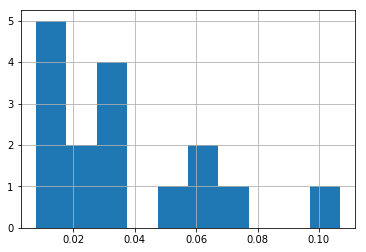

In [73]:
data.a_frac.hist()

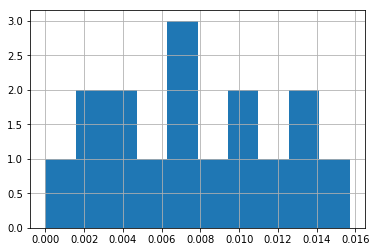

In [74]:
data.b_frac.hist()

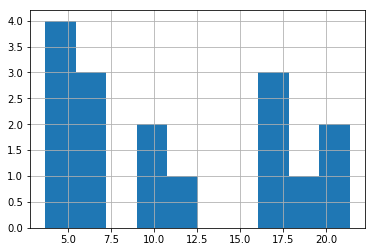

In [75]:
data.total_time.hist()

In [81]:
data.total_time.sum()

180.5462671957672

In [83]:
data.a_length.sum() / 60

5.1618027757919025

In [84]:
data.b_length.sum() / 60

1.3355638845681852

## All annotation concated

In [76]:
annotations_all = pd.concat(annotations)

In [77]:
annotations_all.groupby('label').length.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
,1127.0,8.150584,10.638079,0.035515,2.059811,4.575505,10.047881,107.719381
a,900.0,0.344120,0.153555,0.093000,0.247264,0.316978,0.399668,1.440181
b,409.0,0.195926,0.080837,0.068908,0.141262,0.179161,0.227397,0.849573
c,7.0,25.209390,52.630576,1.344100,2.557695,4.110652,10.838292,144.219000
q,1.0,7.674469,NaN,7.674469,7.674469,7.674469,7.674469,7.674469


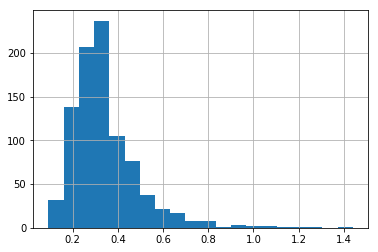

In [78]:
annotations_all[annotations_all.label == 'a'].length.hist(bins=20)

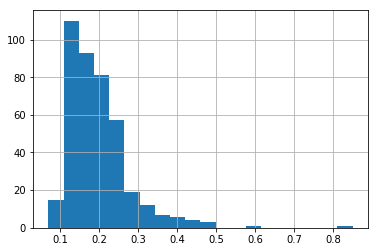

In [79]:
annotations_all[annotations_all.label == 'b'].length.hist(bins=20)

0.3s is good choice

## Audio

In [19]:
audio_paths = [
    '../audio/surf.m4a',
    '../audio/lavina_class.m4a',
    '../audio/dtp.m4a',
    '../audio/artem_vps.m4a',
    '../audio/dima_arxiv.m4a',
    '../audio/sasha_code.m4a',
    '../audio/gomes.m4a',
    '../audio/ksenia.m4a',
    '../audio/dashka.m4a',
    '../audio/cursach1.3gpp'
]

In [20]:
def get_audios(paths):    
    res = []
    for path in paths:
        audio, sr = librosa.load(path)
        res.append(audio)
    return res, sr

def get_label_data(annotation, audio, label, sr):
    start_samples_indxs = librosa.time_to_samples(annotation[annotation.label ==\
                                                              label].start.values, sr)
    finish_samples_indxs = librosa.time_to_samples(annotation[annotation.label ==\
                                                               label].finish.values, sr)
    
    data = []
    for s, f in zip(start_samples_indxs, finish_samples_indxs):
        data.append(audio[np.arange(s, f)])
    return data

def get_unlabel_data(annotation, audio, labels, sr):
    start_samples_indxs = librosa.time_to_samples(\
                          annotation[annotation.label.isin(labels)].start.values, sr)
    finish_samples_indxs = librosa.time_to_samples(\
                           annotation[annotation.label.isin(labels)].finish.values, sr)
    finish_samples_indxs = np.hstack([[0], finish_samples_indxs])
    start_samples_indxs = np.hstack([start_samples_indxs, [len(start_samples_indxs) - 1]])
    
    data = []
    for s, f in zip(finish_samples_indxs, start_samples_indxs):
        data.append(audio[np.arange(s, f)])
    return data

In [21]:
# audios, sr = get_audios(audio_paths[-1:])
audios, sr = get_audios(audio_paths)

In [23]:
lens = [len(a) // sr for a in audios]

In [25]:
np.mean(lens)

749.29999999999995

In [28]:
sum(lens) // 60 # minutes

124